In [1]:
import os
import glob
import pandas as pd
import dabest

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
pwd

'/Users/michaelpiacentino/Drive/git/data/SMPD3/MigrationArea'

In [3]:
# Add analysis date here to apply to dataframe
analysis_date = '20181123'

path = os.path.abspath('')+'/CSVs/'
full_df = pd.DataFrame()
list_ = []

# For loop to bring in files and concatenate them into a single dataframe
for file_ in glob.glob(path + "/*.csv"):
    df = pd.read_csv(file_)
    # Determine Image name from file name
    df['Image'] = os.path.splitext(os.path.basename(file_))[0]
    # Split values in ROI label and Image name columns
    df['delete1'], df['ROI'], df['delete2'], df['delete3'] = zip(*df['Label'].map(lambda x: x.split(':')))
    (df['ExptDate'], df['Treatment'], df['Dose'], df['Stains'], df['Embryo'], 
        df['Somites'], df['ImageMag']) = zip(*df['Image'].map(lambda x: x.split('_')))
    list_.append(df)

full_df = pd.concat(list_)
full_df = full_df.drop(['Label', 'Mean', 'IntDen', 'RawIntDen', 'delete1', 'delete2', 'delete3'], axis=1)
full_df.head()

,,Area,Image,ROI,ExptDate,Treatment,Dose,Stains,Embryo,Somites,ImageMag
0,1,80452.846,"20180630_SMPD3MO_0,8mM_Pax7_Emb5_8ss_10x",CntlArea,20180630,SMPD3MO,"0,8mM",Pax7,Emb5,8ss,10x
1,2,47922.588,"20180630_SMPD3MO_0,8mM_Pax7_Emb5_8ss_10x",ExptArea,20180630,SMPD3MO,"0,8mM",Pax7,Emb5,8ss,10x
0,1,47346.082,"20181119_SMPD3MO_0,6mM_Pax7_Emb6_7ss_10x",CntlArea,20181119,SMPD3MO,"0,6mM",Pax7,Emb6,7ss,10x
1,2,27928.306,"20181119_SMPD3MO_0,6mM_Pax7_Emb6_7ss_10x",ExptArea,20181119,SMPD3MO,"0,6mM",Pax7,Emb6,7ss,10x
0,1,146043.286,"20180630_SMPD3MO_0,8mM_Pax7_Emb3_9ss_10x",CntlArea,20180630,SMPD3MO,"0,8mM",Pax7,Emb3,9ss,10x


In [8]:
# Get a list of treatments
treatment_list = full_df.Treatment.unique()
treatment_list = treatment_list.tolist()

# Group dataframe by treatment
df_byTreatment = full_df.groupby(['Treatment', 'Image', 'ROI'])['Image', 'ROI', 'Area', 'Treatment'].mean()

# Loop trough treatments, performing each analysis and exporting CSV file for each treatment
for i in treatment_list:
    # Slice dataframe to process only embryos with given treatment
    treatment = i
    df_treatment = pd.DataFrame(df_byTreatment.xs(treatment))

    # Extract Cntl and Expt areas
    area_cntl = df_treatment.xs('CntlArea', level='ROI')
    area_expt = df_treatment.xs('ExptArea', level='ROI')

    # Generate Expt/Cntl Area Ratios
    area_ratios = pd.DataFrame(area_expt / area_cntl)
    area_ratios.columns = ['Expt/Cntl Area']

    # Normalize all migration area values to mean of control group
    norm_cntl = area_cntl/(float(area_cntl.mean()))
    norm_cntl.columns = ['Norm Cntl Area']
    norm_expt = area_expt/(float(area_cntl.mean()))
    norm_expt.columns = ['Norm Expt Area']
    norm_areas = pd.concat([norm_cntl, norm_expt], axis=1, sort=False)

    # Combine processed values into single dataframe and output as csv file analysis date + 'MigrationResults.csv'
    area_cntl = pd.DataFrame(area_cntl)
    area_cntl.columns = ['Cntl Area']
    area_expt = pd.DataFrame(area_expt)
    area_expt.columns = ['Expt Area']
    results = pd.concat([area_cntl, area_expt, area_ratios, norm_cntl, norm_expt], axis=1, sort=True)
    results.to_csv(analysis_date + '_' + treatment + '_MigrationResults.csv')

In [10]:
df = pd.read_csv('20181123_SMPD3MO_MigrationResults.csv')
df.head()

,Image,Cntl Area,Expt Area,Expt/Cntl Area,Norm Cntl Area,Norm Expt Area
0,"20180514_SMPD3MO_0,8mM_Pax7Laminin_Emb12_8ss_10x",116506.057,53329.019,0.457736,1.383249,0.633163
1,"20180514_SMPD3MO_0,8mM_Pax7Laminin_Emb13_8ss_10x",97302.020,40681.740,0.418098,1.155244,0.483005
2,"20180514_SMPD3MO_0,8mM_Pax7Laminin_Emb1_8ss_10x",129671.718,61209.660,0.472036,1.539561,0.726728
3,"20180514_SMPD3MO_0,8mM_Pax7Laminin_Emb3_9ss_10x",173182.400,121514.470,0.701656,2.056153,1.442712
4,"20180514_SMPD3MO_0,8mM_Pax7Laminin_Emb6_8ss_10x",72508.322,52025.129,0.717506,0.860874,0.617682


,reference_group,experimental_group,stat_summary,bca_ci_low,bca_ci_high,ci,is_difference,is_paired,pvalue_2samp_paired_ttest,pvalue_wilcoxon
0,Norm Cntl Area,Norm Expt Area,-0.416181,-0.526233,-0.330689,95.0,True,True,8.934936e-09,0.000006


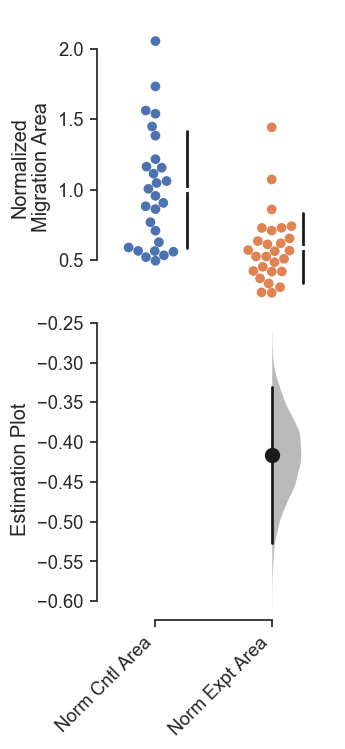

In [19]:
fig1, stats = dabest.plot(df, idx=('Norm Cntl Area', 'Norm Expt Area'),
                            paired=True, show_pairs=False, #defines paired analysis, but shows individual plots
                            id_col='Image', #need to define an ID column for a paired analysis
                            show_group_count=False,
                            font_scale=0.8,
                            dpi=100,
                            #fig_size=(2,6),
                            tick_length=5,
                            float_contrast=False,
                            swarm_dotsize=7,
                            summary_linewidth=2,
                            ci_linewidth=2,
                            swarm_label='Normalized\nMigration Area',
                            contrast_label='Estimation Plot',
                           )
stats

In [21]:
fig1.savefig('smpd3MOMigration.jpg')